In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from time import time

from tqdm import tqdm_notebook as tqdm

%matplotlib inline

from sklearn.datasets import load_svmlight_file

In [2]:
x_train, labels = load_svmlight_file('usps')
x_train = x_train.todense()
labels = labels.astype(int) - 1
h = int(max(labels))+1
m = x_train.shape[1]
n = len(labels)

In [3]:
def multivariate_logloss_one_sample(x,y,w):
    a = w@x.T
    return np.log(np.exp(a).sum()) - w[y]@x.T

def multivariate_logloss(x,y,w):  # for batch
    return sum([multivariate_logloss_one_sample(x[i],y[i],w) for i in range(y.shape[0])])/y.shape[0]

def loss_grad_one_sample(x,y,w):
    c = np.zeros_like(w)
    c[y] = x
    a = w@x.T
    return np.outer(np.exp(a), x)/(np.exp(a).sum()) - c

def loss_grad(x,y,w):
    samples_grad = np.asarray([loss_grad_one_sample(x[i], y[i], w) for i in range(y.shape[0])])
    return samples_grad.mean(axis = 0)

In [4]:
def simplex_projection(s,R):
    if np.sum(s) <= R and np.alltrue(s >= 0):
        return s
    # Code taken from https://gist.github.com/daien/1272551
    u = np.sort(s)[::-1]
    cssv = np.cumsum(u)
    try:
        rho = np.nonzero(u * np.arange(1, len(u)+1) > (cssv - R))[0][-1]
    except IndexError:
        rho = 0
    theta = (cssv[rho] - R) / (rho + 1.0)
    return np.maximum(s-theta, 0)

def nuclear_projection(A,R):
    U, s, V =  np.linalg.svd(A, full_matrices=False)
    s = simplex_projection(s,R)
    return U.dot(np.diag(s).dot(V))

In [5]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert inputs.shape[0] == targets.shape[0]
    if shuffle:
        indices = np.arange(inputs.shape[0])
        np.random.shuffle(indices)
    for start_idx in range(0, inputs.shape[0] - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

Text(0,0.5,'loss')

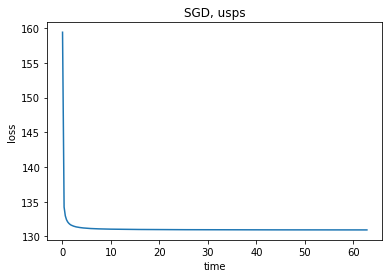

In [6]:
n_iter = 250
batch_size = 100
step = 1e-2
w = np.load('losses/w.npy')[0]
R = 50
start_time = time()
times = []
indices = np.random.randint(0, n, batch_size)
loss_history = [multivariate_logloss(x_train[indices], labels[indices], w)]
times.append(round(time() - start_time, 2))


for i in tqdm(range(n_iter)):
    j = 0
    step = 1/(h*(i+1)**2)
    indices = np.random.randint(0, len(labels), batch_size)
    grad = loss_grad(x_train[indices], labels[indices], w)
    w = w-step*grad
    w = nuclear_projection(w, R)
    j += 1
    loss_history.append(multivariate_logloss(x_train, labels, w))
    times.append(round(time() - start_time, 2))

loss_history = np.asarray(loss_history).squeeze()
times = np.asarray(times).squeeze()


plt.plot(times, loss_history)
plt.title('SGD, usps')
plt.xlabel('time')
plt.ylabel('loss')

In [7]:
np.save('losses/losses_SGD', loss_history)
np.save('losses/times_SGD', times)